In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from astropy.io import fits
from sklearn.cluster import DBSCAN
from analyzeImage import analyzeImage as ai
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


In [5]:
hdu = fits.open('../../HITS/trimmed_chip_03/Blind15A_02/search_nights/trimmed_calexp-0410841_03.fits')
#hdu = fits.open('../../HITS/trimmed_chip_03/Blind15A_02/search_nights/trimmed_calexp-0410891_03.fits')
#hdu = fits.open('../../HITS/chip_03/Blind15A_01/calexp-0410840_03.fits.gz')
#hdu = fits.open('../code/gpu/output-images/psi/T001psi.fits')

In [8]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
MJD     =        57070.0405161                                                  
EC_ANGLE=    1.258297013810378                                                  

In [38]:
hdu = fits.open('../../HITS/trimmed_chip_04/Blind15A_02/search_nights/trimmed_calexp-0410841_04.fits')

In [39]:
hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1970                                                  
NAXIS2  =                 3978                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               

In [31]:
hdu[1].header.keys()[0] in hdu[2].header.keys()

True

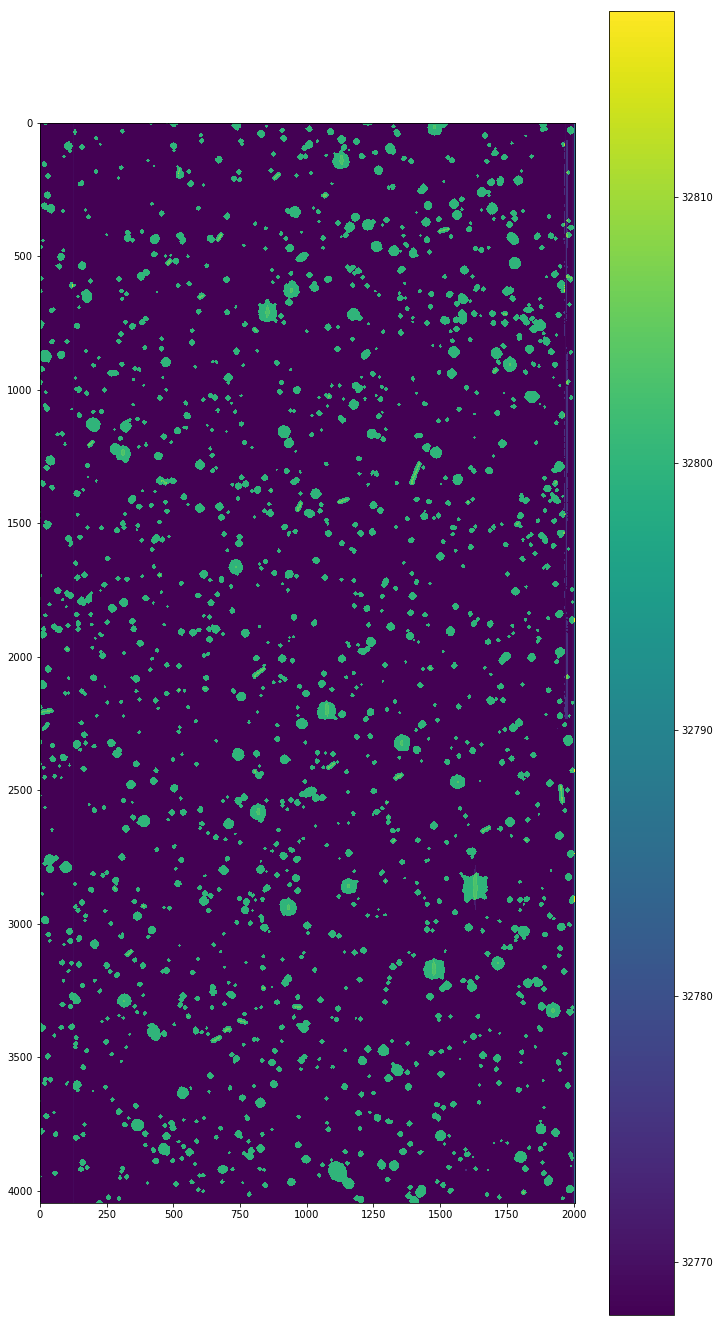

In [35]:
fig = plt.figure(figsize=(12, 24))
plt.imshow(hdu[2].data)#, vmax=2, vmin=0)
plt.colorbar()

In [8]:
def write_param_file():
    paramsFile = open('../code/gpu/debug/parameters.config', 'w')
    paramsFile.write(
    """Debug ................ : 1
    PSF Sigma ............ : 1.0
    Mask Threshold ....... : 0.75
    Mask Penalty ......... : -0.05
    Slope Reject Threshold : 1000.0
    Angles to Search ..... : 20
    Minimum Angle ........ : 0.0
    Maximum Angle ........ : 6.283
    Velocities to Search . : 20
    Minimum Velocity ..... : 24.
    Maximum Velocity ..... : 600.
    Psi/Phi to file ...... : 1
    Source Images Path ... : ../../{source}/
    Psi Images Path ...... : ../../{psi}/
    Phi Images Path....... : ../../{phi}/
    Results Path ......... : ../../../data/results/{name}.txt
    """.format( source=real_image_path, psi=psi_image_path, phi=phi_image_path, name=results_name ))
    paramsFile.close()

In [9]:
def trim_on_lc(clustered_results, im_array, image_times):
    
    f_results = clustered_results        
    keep_results = []
    light_curves = []
    ai_2 = analyzeImage()
    
    for current in range(len(f_results)):
        traj_coords = ai_2.calc_traj_coords(f_results[current], image_times)
        light_curve = [im_array[x, traj_coords[x,1], traj_coords[x,0]] for x in range(len(im_array))]
        if np.max(light_curve) < 10*np.median(light_curve):
            keep_results.append(current)
            light_curves.append(light_curve)
        
    return f_results[keep_results], light_curves

In [10]:
def create_stamps(im_array, kept_results, image_times):
    
    f_results = kept_results#filtered_results
    postage_stamps = []
    ai_2 = analyzeImage()
    for imNum in range((len(f_results))):
        current = imNum#best_targets[imNum]
        ps = ai_2.createPostageStamp(im_array,
                                  list(f_results[['t0_x', 't0_y']][current]),
                                  np.array(list(f_results[['v_x', 'v_y']][current])), 
                                  image_times, [25., 25.])
        postage_stamps.append(ps[0])
                       
    return postage_stamps

In [11]:
def process_results():
    #Load results
    raw_results = np.genfromtxt('../data/results/HITS1.txt', names=True)
    
    #Load times
    image_mjd = []

    for filename in sorted(os.listdir(real_image_path)):
        hdulist = fits.open(os.path.join(real_image_path, filename))
        image_mjd.append(hdulist[0].header['MJD'])

    image_mjd = np.array(image_mjd)
    image_times = image_mjd - image_mjd[0]
    
    #Load images
    hdulist = fits.open(os.path.join(real_image_path, os.listdir(real_image_path)[0]))
    num_images = len(os.listdir(real_image_path))
    image_shape = np.shape(hdulist[1].data)
    im_array = np.zeros((num_images, image_shape[0], image_shape[1]))


    for idx, filename in list(enumerate(sorted(os.listdir(real_image_path)))):

       # print( str('Loaded ' + filename))

        image_file = os.path.join(real_image_path, filename)
        hdulist = fits.open(image_file)
        im_array[idx] = hdulist[1].data#*mask
    
    ai = analyzeImage()
    
    model = load_model('../data/kbmod_model.h5')
    
    results = raw_results[np.where(raw_results['likelihood'] >= 5.0)]
    
    filtered_results = ai.filter_results(im_array, results, image_times, model, chunk_size=5000)
    
    results_to_cluster = filtered_results
    arg = dict(eps=0.03, min_samples=1, n_jobs=-1)
    clustered_results = ai.clusterResults(results_to_cluster, dbscan_args=arg)#, im_array, image_times)
    clustered_results =  results_to_cluster[np.array(clustered_results[1], dtype=np.int)]
    
    kept_results, light_curves = trim_on_lc(clustered_results, im_array, image_times)
    stamps = create_stamps(im_array, kept_results, image_times)
    return kept_results, light_curves, stamps, image_times

In [ ]:
for chip_num in ['03']:#['01', '03', '04', '05']:
    chip_results = []
    chip_lc = []
    chip_stamps = []
    chip_times = []
    field_id = []
    df = pd.DataFrame(columns=['t0_x', 't0_y', 'theta_par', 'theta_perp', 'v_x', 
                               'v_y', 'likelihood', 'est_flux', 'field_num'])
    for field_num in xrange(1,57):
        if field_num < 10:
            real_image_path = str("../../HITS/trimmed_chip_" + str(chip_num) + 
                                  "/Blind15A_0" + str(field_num) + "/search_nights")
        else:
            real_image_path = str("../../HITS/trimmed_chip_" + str(chip_num) + 
                                  "/Blind15A_" + str(field_num) + "/search_nights")
        results_name = "HITS1"
        gpu_code_path = "../code/gpu/"
        psi_image_path = gpu_code_path+"output-images/psi"
        phi_image_path = gpu_code_path+"output-images/phi"
        
        write_param_file()
        
        !cd ~/cuda-workspace/kbmod/code/gpu/debug/; ./clearImages.sh
        !cd ~/cuda-workspace/kbmod/code/gpu/debug/; ./CudaTracker
        
        try:
            kept_results, light_curves, stamps, image_times = process_results()
            field_df = pd.DataFrame.from_records(kept_results)
            field_df['field_num'] = field_num
            df = df.append(field_df)
            for lc, stamp in zip(light_curves, stamps):
                chip_lc.append(lc)
                chip_stamps.append(stamp)
                chip_times.append(image_times)
                field_id.append(field_num)
        except:
            continue
    df.to_csv(str(str(chip_num) + '_results.csv'), index=False)
    fig = plt.figure(figsize=(8, 3*len(field_id)))
    for lc, stamp, plot_num, image_time_set in zip(chip_lc, chip_stamps, np.arange(len(field_id)), chip_times):
        fig.add_subplot(len(field_id),2,2*plot_num + 1)
        plt.imshow(stamp, origin='lower', interpolation='None')
        plt.title(str(field_id[plot_num]))
        fig.add_subplot(len(field_id),2,2*plot_num + 2)
        plt.plot(image_time_set, lc)
        plt.xlabel('Time (days)')
        plt.ylabel('Flux')
        plt.tight_layout()
    plt.savefig(str(str(chip_num) + '_stamps.png'))

rm: cannot remove '../output-images/psi/*.fits': No such file or directory
rm: cannot remove '../output-images/phi/*.fits': No such file or directory
    PSF Sigma ............  : 1.0
    Mask Threshold .......  : 0.75
    Mask Penalty .........  : -0.05
    Slope Reject Threshold  : 1000.0
    Angles to Search .....  : 20
    Minimum Angle ........  : 0.0
    Maximum Angle ........  : 6.283
    Velocities to Search .  : 20
    Minimum Velocity .....  : 24.
    Maximum Velocity .....  : 600.
    Psi/Phi to file ......  : 1
    Source Images Path ...  : ../../../../HITS/trimmed_chip_03/Blind15A_01/search_nights/
    Psi Images Path ......  : ../../../code/gpu/output-images/psi/
    Phi Images Path.......  : ../../../code/gpu/output-images/phi/
    Results Path .........  : ../../../data/results/HITS1.txt
Using Kernel Size 5X5
| 0.004 | 0.015 | 0.023 | 0.015 | 0.004 | 
 ---------------------------------------
| 0.015 | 0.058 | 0.093 | 0.058 | 0.015 | 
 -----------------------------------

KeyboardInterrupt: 

In [ ]:
!ls ../